In [4]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Output, Input
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
from useful_func import *
JupyterDash.infer_jupyter_proxy_config()



In [5]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.title = "FluoDL"

# Create server variable with Flask server object for use with gunicorn
server = app.server

I_480_map = np.load("../images/I_480_map.npy")
print(I_480_map.shape)
video_2D = np.load("../images/video_2D.npy")
print(video_2D.shape)
framerate = np.load("../images/framerate.npy")


maxi = int(I_480_map.max())
mini = int(I_480_map.min())
step  = (maxi-mini)//10

def create_distribution(I_map_0, maxi, mini):
    I_map = np.copy(I_map_0)
    maxi = np.quantile(I_map_0, maxi)
    mini = np.quantile(I_map_0, mini)
    I_map[I_map>maxi] = maxi
    I_map[I_map<mini] = mini
    fig = px.imshow(I_map)
    fig.update_traces(hovertemplate="x: %{x} <br> y: %{y} <br> z: %{z}")
    fig.update_layout(coloraxis=dict(colorbar=dict(orientation='h')))
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    print(np.mean(I_map))
    return fig

fig_init = create_distribution(I_480_map, 1, 0)



# Create server variable with Flask server object for use with gunicorn

app.layout = html.Div([

        html.Div([            
            html.Label("Min value"),


            dcc.Slider(
            id="mini",
            min=0,
            max=0.5,
            value=0.01,
        ),
            
        html.Label("Max value"),
            dcc.Slider(
            id = "maxi",   
            min=0.5,
            max=1,
            value= 0.99,
        ),
        ], style={'width':'30%'}
        ),
        html.Div([
            
                dcc.Graph(id="distribution", figure = fig_init),
                
                dcc.Graph(id="trace", hoverData={'points': [{'hovertext': "0_0_0/3/1"}]}),

        ],
        style={'width': '49%', 'display': 'inline-block'}),
]
)


def create_trace(time, trace):
    params = simple_tau(trace, time, sample_rate = framerate)
    time = time/framerate

    y = exp_decay(params, time)

    trace1 = go.Scatter(
        mode = "markers",
        x=time,
        y=trace,
        name="raw",
        marker=dict(
            color='rgb(34,163,192)'
                   )
    )
    trace2 = go.Scatter(
        x=time,
        y=y,
        name='fit',)

    fig_trace = make_subplots()
    fig_trace.add_trace(trace1)
    fig_trace.add_trace(trace2)    
    fig_trace.add_annotation(x=0, y=0.85, xanchor='left', yanchor='bottom',
                       xref='paper', yref='paper', showarrow=False, align='left', text = "",
                       )
    fig_trace.update_layout(plot_bgcolor='rgba(255,255,255,1)')
    return fig_trace

@app.callback(
    Output('distribution', 'figure'),
    [Input('maxi', 'value'),
    Input('mini', 'value')])
def update_figure(maxi, mini):
    return create_distribution(I_480_map, maxi, mini)


@app.callback(
    Output('trace', 'figure'),
    [Input('distribution', 'hoverData')])
def update_trace(hoverData):
    x = hoverData['points'][0]["x"]
    y = hoverData['points'][0]["y"]
    trace = video_2D[:, y,x]
    time = np.linspace(0, len(trace)-1, len(trace))
    return create_trace(time, trace)




(128, 128)
(50, 128, 128)
54.14278938535092


In [6]:
app.run_server(mode="jupyterlab")

48.96738724835386


G:\DREAM\from_github\light_calibration\notebooks\useful_func.py:22: RuntimeWarning:

overflow encountered in exp



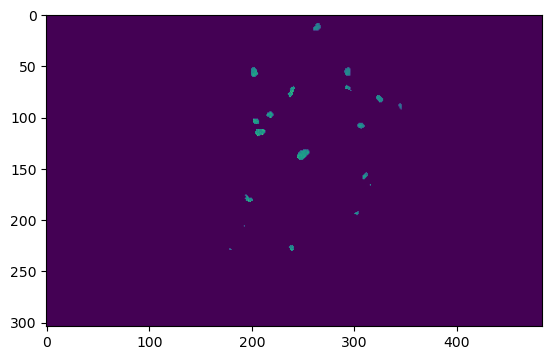

In [4]:
plt.imshow(I_480_map)